<p align="center">
  <img src="https://github.com/mastixstudio/notebooks/blob/main/assets//welcome.png?raw=true" alt="Styled DataFrame" style="width: 100%;">
</p>

## IRRBB and balance sheet risks
#### Two perspectives on the balance sheet
#### Consistent projection

## Python example
#### Calendars, counterparties and market data
#### Fixed rate loan
- ##### Present value and risks
- ##### Liquidity
- ##### NII: contractual and IFRS 9
#### Floating rate loan
- ##### NII risks
   
    
    
    
    
---

## IRRBB and balance sheet risks

### Two perspectives on the balance sheet

<p align="left">
  <img src="https://github.com/mastixstudio/notebooks/blob/main/assets/balance-sheet-perspectives.png?raw=true" alt="Styled DataFrame" style="width: 50%;">
</p>

Where   
**C(t) = Cash**,   
**A(t)= Other assets**,   
**L(t) = Liabilities**, and   
**E(t) = Equity**.

We also want to analyze the evolution of the balance sheet, e.g., $$C(t_N)=C(t_0)+\sum_{n=1}^N \Delta C(t_{i-1},t_i).$$

## Consistent projection of the balance sheet

<p align="left">
  <img src="https://github.com/mastixstudio/notebooks/blob/main/assets/cash-flow-split.png?raw=true" alt="Styled DataFrame" style="width: 70%;">
</p>

Align all measures to a common time-grid — split cash flows.

## Python Example

In [6]:
pathData           = 'C:\\Data'
pathMarketData     = 'C:\\Data\\MarketData'
pathCalendars      = 'C:\\Data\\Calendars'
pathCounterparties = 'C:\\Data\\Counterparties'
pathTrades         = 'C:\\Data\\Trades'

#### Load calendars and counterparties as well as set current date

In [7]:
calendarMap     = JsonSerializer.LoadCalendarMapFromFile(os.path.join(pathCalendars, 'CalendarMap.json'))
counterpartyMap = JsonSerializer.LoadCounterpartyMapFromFile(os.path.join(pathCounterparties, 'CounterpartyMap.json'))

loadMap = LoadMap(calendarMap, counterpartyMap)

stockholm = calendarMap.GetCalendar('Stockholm')
target    = calendarMap.GetCalendar('Euro')

date = Date(2022, 7, 19)

#### Load market data

In [8]:
marketDataMapMap = JsonSerializer.LoadMarketDataMapMapFromFile(os.path.join(pathMarketData, f'MarketDataMapMap {date.ToString()}.json'), OuterTape(), loadMap)

calculatorMapBase              = CalculatorMap(marketDataMapMap.GetMarketDataMap('Base'))
calculatorMapBuckets           = CalculatorMap(marketDataMapMap.GetMarketDataMap('Buckets'))
calculatorMapSot               = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot'))
calculatorMapSotParallelUp     = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Parallel Up'))
calculatorMapSotParallelDown   = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Parallel Down'))
calculatorMapSotSteepener      = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Steepener'))
calculatorMapSotFlattener      = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Flattener'))
calculatorMapSotShortRatesUp   = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Short Rates Up'))
calculatorMapSotShortRatesDown = CalculatorMap(marketDataMapMap.GetMarketDataMap('Sot Short Rates Down'))

---

#### Create a 3W fixed amortised loan

In [9]:
currency = CurrencyCode.SEK
notionalStart = 250e6
notionalEnd = 0
fixedId = '3W Fixed Amortised Loan'
counterparty = 'Annas bak'
fee = 10000

In [10]:
fixedNotionalStart = OuterReverse(notionalStart, fixedId + ' Notional Start', currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0)
fixedNotionalEnd   = OuterReverse(notionalEnd,   fixedId + ' Notional End'  , currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0)

payScheduler = BackwardScheduler(Frequency.Weekly, EndOfMonthConvention.SameDay, StubConvention.Long, NoDayAdjustment.Static)

fixedNotionalSequence = LinearTargetSequence(fixedNotionalStart, fixedNotionalEnd)

fixedGenericInstrument0 = GenericFixedStream(ZeroPeriod.Static, currency, ZeroPeriod.Static, WeeksPeriod(3), payScheduler, ModifiedFollowingDayAdjustment(stockholm), False, True, False, Actual360DayCount.Static, SimpleRate(OuterReverse.ZeroHidden), fixedNotionalSequence)

fixedInstrument0 = fixedGenericInstrument0.CreateInstrument(OuterTape(), date)

#### Calculate rate components

In [11]:
fixedInstrumentCalculator1 = Python.Cast[StreamCalculator](calculatorMapSot.GetCalculator(fixedInstrument0))

fixedRate1 = fixedInstrumentCalculator1.RateTargetPresentValue(OuterTape(), date, currency, True, OuterReverse.ZeroHidden, 0.03, 1e-7)

fixedMarketRate = Constant(fixedRate1.Value, fixedId + ' Market Rate', '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)

In [12]:
fixedInstrumentCalculator2 = Python.Cast[StreamCalculator](calculatorMapSot.GetCalculator(fixedInstrument0, calculatorMapSot.MarketDataMap.GetSurvivalCurve(counterpartyMap.GetCounterparty(counterparty).RiskClass)))

fixedRate2 = fixedInstrumentCalculator2.RateTargetPresentValue(OuterTape(), date, currency, True, OuterReverse.ZeroHidden, 0.03, 1e-7)

fixedExpectedCreditLossSpread = Constant((fixedRate2.Value - fixedRate1.Value), fixedId + ' Expected Credit Loss Spread', 'bp', 10000.0, 'bp', 10000.0, NumberFormat.Dp2)

In [13]:
fixedMargin = Constant(50/100/100, fixedId + ' Margin', 'bp', 10000.0, 'bp', 10000.0, NumberFormat.Dp2)

In [14]:
fixedRateComponents = SimpleList[RateComponent](RateComponent.Market, RateComponent.Credit, RateComponent.Margin)
fixedRates          = SimpleList[OuterReverse](OuterReverse(fixedMarketRate), OuterReverse(fixedExpectedCreditLossSpread), OuterReverse(fixedMargin))

fixedRate = StackedRate(fixedRateComponents, fixedRates)

#### Examine the fixed rate stack

In [15]:
for component in fixedRate:
    print(f'{component.Item1} {component.Item2.ConstantNullable.FormatConstant(True):>18}')

print(f'{"Total rate"} {fixedRate.Top(OuterTape()).AccumulateDerivatives("%", 100.0, NumberFormat.Dp4).FormatValue(True):>14}')

Market           0.6932 %
Credit           23.70 bp
Margin           50.00 bp
Total rate       1.4302 %


#### Create final loan

In [16]:
fixedInstrument1 = Python.Cast[Stream](fixedInstrument0).SetRate(OuterTape(), fixedRate)

fixedFee1 = Payment(currency, date, OuterReverse(fee, fixedId + ' Fee', currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0), PaymentType.Fee)
   
fixedLoan = Trade(fixedId, OuterReverse.OneHidden, fixedInstrument1, fixedFee1, counterpartyMap.GetCounterparty(counterparty), None)

#### Create calculator

In [17]:
fixedLoanCalculator = calculatorMapSot.GetCalculator(fixedLoan, calculatorMapSot.MarketDataMap.GetSurvivalCurve('Risk Class 0'))

---

#### Present value

In [18]:
fixedPresentValue = fixedLoanCalculator.PresentValue(OuterTape(), date, currency, False).AccumulateDerivatives(currency.ToString(), 1, NumberFormat.Dp2, NumberFormat.Dp4)

print(f'Present value {fixedPresentValue.FormatValue(True)}\n')

Present value 250 071 640.04 SEK



#### Sensitivities
Almost all calculations also contains the sensitivities to all risk factors driving the calculated value.

In [19]:
for derivative in fixedPresentValue:
    print(f'{derivative.Constant.Id:55} {fixedPresentValue.FormatDerivative(derivative, True):>18} {fixedPresentValue.FormatConstant(derivative, True):>18}')

Stibor/TN Fixing Rate                                       21.7670 SEK/bp           0.6840 %
Stibor/TN Ois 1W Rate                                     -763.3663 SEK/bp           0.6840 %
Stibor/TN Ois 1W Spread                                    763.3663 SEK/bp            0.00 bp
Stibor/TN Ois 1M Rate                                     -255.6825 SEK/bp           0.7230 %
Stibor/TN Ois 1M Spread                                    255.6825 SEK/bp            0.00 bp
Stibor/TN Ois 2M Rate                                       25.1498 SEK/bp           0.7240 %
Stibor/TN Ois 2M Spread                                    -25.1498 SEK/bp            0.00 bp
Stibor/TN Ois 3M Rate                                        0.0000 SEK/bp           1.0780 %
Stibor/TN Ois 3M Spread                                     -0.0000 SEK/bp            0.00 bp
Stibor/TN Ois 6M Rate                                        0.0000 SEK/bp           1.6440 %
Stibor/TN Ois 6M Spread                                     

#### Filtering
Although useful in many cases, the benchmark risks are not that interesting here so we create a filter to shorten the sensitivity table.

In [20]:
print(f'Present value {fixedPresentValue.FormatValue(True)}\n')

filter = NotDerivativeFilter(DerivativeIdWildcardFilter(Wildcard('Stibor*', True, True)))

for derivative in fixedPresentValue.GetDerivatives(filter):
    print(f'{derivative.Constant.Id:55} {fixedPresentValue.FormatDerivative(derivative, True):>18} {fixedPresentValue.FormatConstant(derivative, True):>18}')

Present value 250 071 640.04 SEK

Risk Class 0.1W                                           -159.9294 SEK/bp            0.00 bp
Risk Class 0.Parallel                                     -959.0460 SEK/bp            0.00 bp
Risk Class 0.2W                                           -319.7269 SEK/bp            0.00 bp
Risk Class 0.3W                                           -479.3897 SEK/bp            0.00 bp
PD Risk Class 0                                           -575.4276 SEK/bp            0.00 bp
LGD                                                         -0.0000 SEK/pp            60.00 %
SEK.DSC.1W                                                -158.8247 SEK/bp            0.00 bp
SEK.DSC.Parallel                                          -952.3298 SEK/bp            0.00 bp
SEK.DSC.2W                                                -317.5041 SEK/bp            0.00 bp
SEK.DSC.3W                                                -476.0010 SEK/bp            0.00 bp
Sot Parallel Up (SEK)     

---

#### SOT flattener scenario 
We can, for example, see that the SOT flattener scenario contributes to the present value with around -2 250 SEK per percentage point so we expect the impact from the full flattener scenario to be around -2 250 * 100.

In [21]:
fixedPresentValueSotFlattener = calculatorMapSotFlattener.GetCalculator(fixedLoan).PresentValue(OuterTape(), date, currency, False).AccumulateDerivatives(currency.ToString(), 1, NumberFormat.Dp2, NumberFormat.Dp4)

print(f'Flattener present value {fixedPresentValueSotFlattener.FormatValue(True)}')
print()
print(f'Flattener real scenario {NumberFormat.Dp2.Format((fixedPresentValueSotFlattener.Value - fixedPresentValue.Value))} SEK vs scenario from risk {NumberFormat.Dp2.Format(fixedPresentValue.GetDerivative("Sot Flattener (SEK)").Value)} SEK\n')

for derivative in fixedPresentValueSotFlattener.GetDerivatives(filter):
    print(f'{derivative.Constant.Id:55} {fixedPresentValueSotFlattener.FormatDerivative(derivative, True):>18} {fixedPresentValueSotFlattener.FormatConstant(derivative, True):>18}')

Flattener present value 249 849 290.06 SEK

Flattener real scenario -222 349.98 SEK vs scenario from risk -225 065.36 SEK

SEK.DSC.1W                                                -155.0815 SEK/bp            0.00 bp
SEK.DSC.Parallel                                          -929.5296 SEK/bp            0.00 bp
SEK.DSC.2W                                                -309.9314 SEK/bp            0.00 bp
SEK.DSC.3W                                                -464.5168 SEK/bp            0.00 bp
Sot Flattener (SEK)                                     -2 196.7719 SEK/pp            100.0 %
3W Fixed Amortised Loan Notional Start                      0.9994 SEK/SEK    250 000 000 SEK
3W Fixed Amortised Loan Notional End                       -0.0003 SEK/SEK              0 SEK
3W Fixed Amortised Loan Market Rate                        971.2829 SEK/bp           0.6932 %
3W Fixed Amortised Loan Expected Credit Loss Spread        971.2829 SEK/bp           23.70 bp
3W Fixed Amortised Loan Margin 

---

#### Expected credit loss
We can also see, from above, that changes in probability of default (pd) from 'Risk class 0' (pd set to zero) contribute to the present value with around -575 SEK/bp so we expect the impact from applying the 'Risk class 3' survival curve to be around -575 * 40.

In [22]:
fixedPresentValueExpectedCreditLoss = calculatorMapSot.GetCalculator(fixedLoan, True).PresentValue(OuterTape(), date, currency, False).AccumulateDerivatives(currency.ToString(), 1, NumberFormat.Dp2, NumberFormat.Dp4)

print(f'Expected credit loss present value {fixedPresentValueExpectedCreditLoss.FormatValue(True)}')
print()
print(f'Expected credit real scenario {NumberFormat.Dp2.Format((fixedPresentValueExpectedCreditLoss.Value - fixedPresentValue.Value))} SEK vs scenario from risk {NumberFormat.Dp2.Format(fixedPresentValueExpectedCreditLoss.GetConstant("PD Risk Class 3").Value * fixedPresentValue.GetDerivative("PD Risk Class 0").Value)} SEK\n')

for derivative in fixedPresentValueExpectedCreditLoss.GetDerivatives(filter):
    print(f'{derivative.Constant.Id:55} {fixedPresentValueExpectedCreditLoss.FormatDerivative(derivative, True):>18} {fixedPresentValueExpectedCreditLoss.FormatConstant(derivative, True):>18}')

Expected credit loss present value 250 048 596.51 SEK

Expected credit real scenario -23 043.53 SEK vs scenario from risk -23 017.10 SEK

Risk Class 3.1W                                           -159.5382 SEK/bp            0.00 bp
Risk Class 3.Parallel                                     -956.6415 SEK/bp            0.00 bp
Risk Class 3.2W                                           -318.9302 SEK/bp            0.00 bp
Risk Class 3.3W                                           -478.1730 SEK/bp            0.00 bp
PD Risk Class 3                                           -576.7500 SEK/bp           40.00 bp
LGD                                                       -384.5000 SEK/pp            60.00 %
SEK.DSC.1W                                                -158.8174 SEK/bp            0.00 bp
SEK.DSC.Parallel                                          -952.2274 SEK/bp            0.00 bp
SEK.DSC.2W                                                -317.4748 SEK/bp            0.00 bp
SEK.DSC.3W      

---

#### Aligned time grid
In order to distribute our metrics over the future time intervals of interest, relative (i.e. 1D, 1W, 1M etc.) or absolute (i.e Week 26, February or Q2-23) we create a time grid. Here, we want to see daily effects so we choose a daily grid.

In [23]:
periodStartDates = SimpleList[Date]()

for i in range(22):
    periodStartDates.Add(date + i)

fixedLiquidityCashFlows = fixedLoanCalculator.ProjectedLiquidity(OuterTape(), date, True, periodStartDates, None, None)

fixedLiquidityCollection = LiquidityCashFlowPeriodsCollection(periodStartDates, fixedLiquidityCashFlows, None)

#### Liquidity

In [24]:
fixedPeriodValues = fixedLiquidityCollection.PeriodValues(OuterTape(), date, currency, False, None, -1, Dictionary[RateComponent, List[OuterReverse]](), None)

fixedPeriodValuesTable = LiquidityCashFlowPeriodsTable(periodStartDates, -1, fixedPeriodValues[0], fixedPeriodValues[1], False)

CreateDataFrameFixed([[None, fixedPeriodValuesTable]], fixedRateComponents, False)

,Value,Principal,Interest,Market,Credit,Margin
Period Start,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-20,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-21,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-22,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-23,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-24,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-25,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-26,83 402 857.96 SEK,83 333 333.33 SEK,69 524.63 SEK,33 696.60 SEK,11 522.48 SEK,24 305.56 SEK


---

#### Present value
However, distribution of present value due to time value of money might be more interesting since that view helps us to manage bank book risk from both an EVE and an NII (shown later) perspective.

In [25]:
print(f'Present value as a reminder {fixedPresentValue.FormatValue(True)}\n')

fixedPeriodPresentValues = fixedLiquidityCollection.PeriodPresentValues(OuterTape(), date, currency, False, -1, Dictionary[RateComponent, List[OuterReverse]](), None)

fixedPeriodPresentValuesTable = LiquidityCashFlowPeriodsTable(periodStartDates, -1, fixedPeriodPresentValues[0], fixedPeriodPresentValues[1], False)

CreateDataFrameFixed([[None, fixedPeriodPresentValuesTable]], fixedRateComponents, False)

Present value as a reminder 250 071 640.04 SEK



,Value,Principal,Interest,Market,Credit,Margin
Period Start,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,5 178.31 SEK,-4 752.46 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-20,5 180.95 SEK,-4 749.82 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-21,5 183.59 SEK,-4 747.18 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-22,5 185.68 SEK,-4 745.09 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-23,5 186.67 SEK,-4 744.10 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-24,5 186.00 SEK,-4 744.77 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-25,5 183.12 SEK,-4 747.65 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-26,3 450.76 SEK,-3 168.86 SEK,6 619.62 SEK,3 208.34 SEK,1 097.09 SEK,2 314.20 SEK


#### Sensitivities
The distribution of the present value might be easier to see in a plot where we also can add some sensitivites to **each** future time interval.

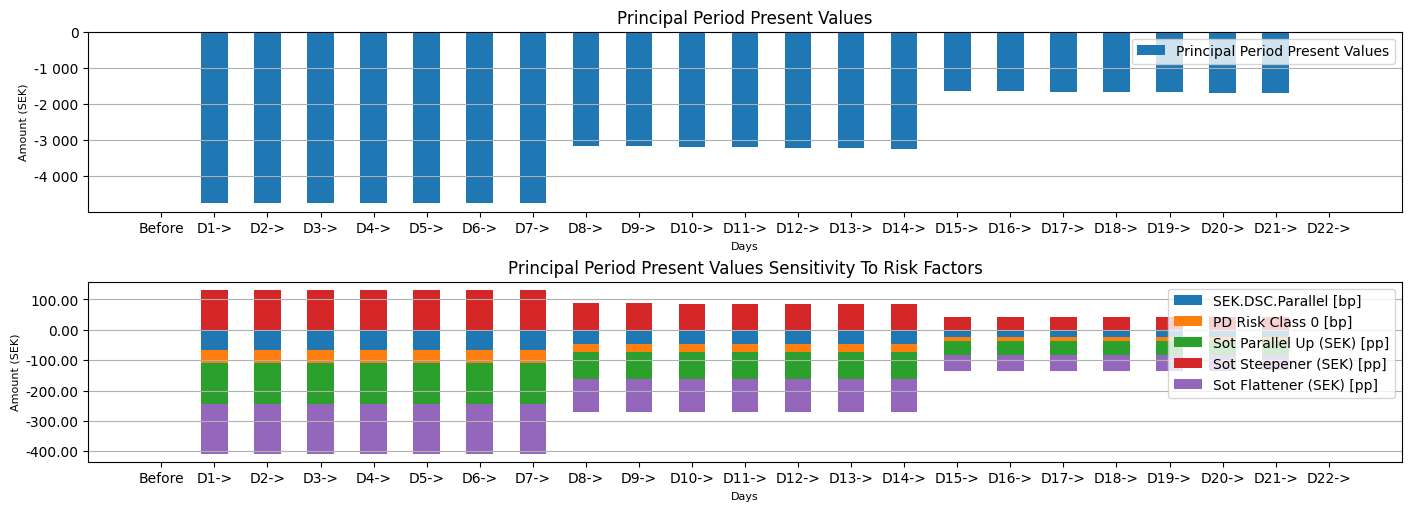

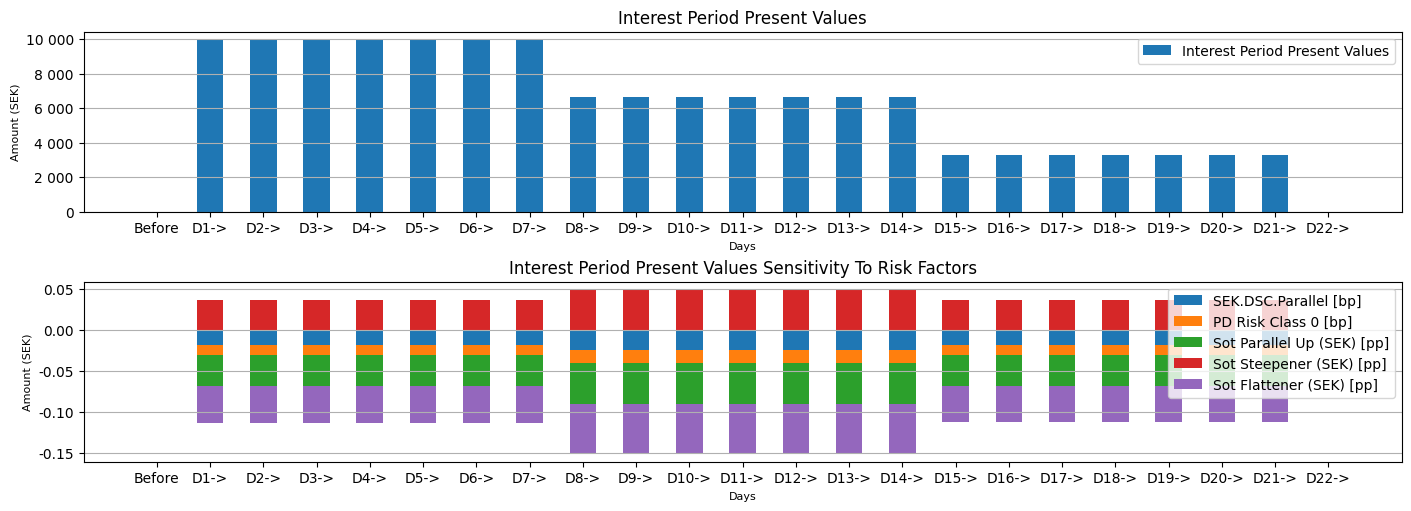

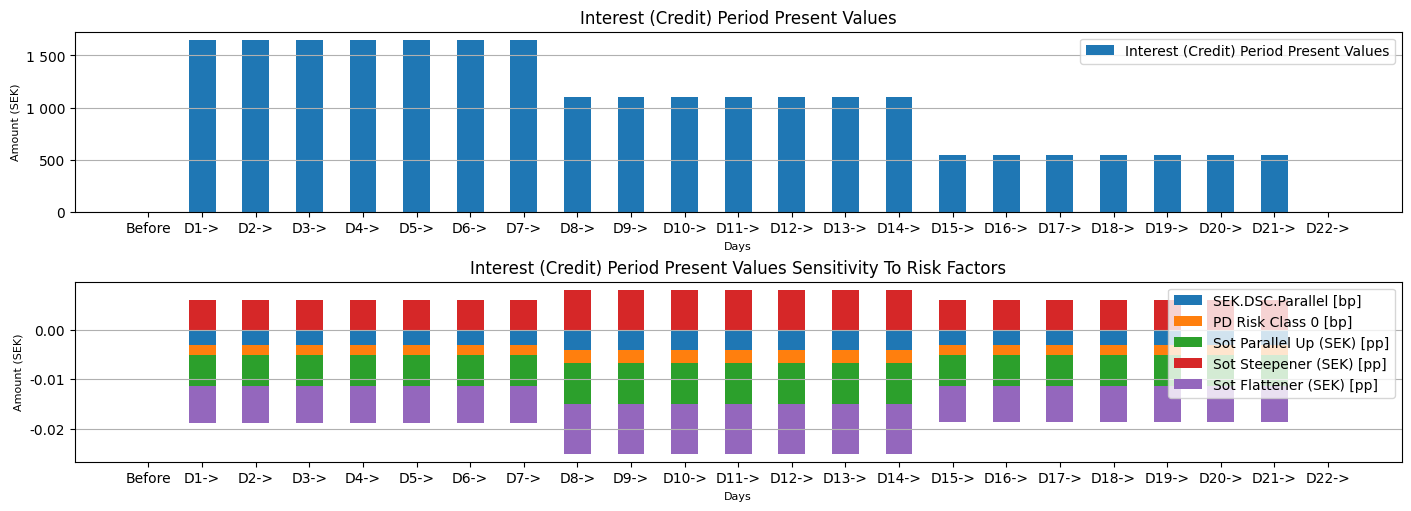

In [26]:
s1 = fixedPeriodPresentValuesTable.PrincipalPeriodValuesNullable(OuterTape())
s2 = fixedPeriodPresentValuesTable.InterestPeriodValuesNullable(OuterTape())
s3 = fixedPeriodPresentValuesTable.InterestPeriodValuesNullable(OuterTape(), fixedRateComponents[1])

plt1 = CreatePlot('Principal Period Present Values',          s1, ['SEK.DSC.Parallel', 'PD Risk Class 0', 'Sot Parallel Up (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)'])
plt2 = CreatePlot('Interest Period Present Values',           s2, ['SEK.DSC.Parallel', 'PD Risk Class 0', 'Sot Parallel Up (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)'])
plt3 = CreatePlot('Interest (Credit) Period Present Values',  s3, ['SEK.DSC.Parallel', 'PD Risk Class 0', 'Sot Parallel Up (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)'])

plt1.show()
plt2.show()
plt3.show()

---

#### Contractual NII / accrued interest
Before looking into NII and its sensitivites fully in line with the accounting rules, IFRS9, we can look at the contractual accrued interest.

In [27]:
fixedPeriodAccruedInterests = fixedLiquidityCollection.PeriodAccruedInterests(OuterTape(), date, currency, False, -1, Dictionary[RateComponent, List[OuterReverse]](), None)

fixedPeriodAccruedInterestsTable = LiquidityCashFlowPeriodsTable(periodStartDates, -1, None, fixedPeriodAccruedInterests, False)

CreateDataFrameFixed([[None, fixedPeriodAccruedInterestsTable]], fixedRateComponents, False)

,Interest,Market,Credit,Margin
Period Start,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-20,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-21,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-22,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-23,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-24,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-25,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK
2022-07-26,6 621.39 SEK,3 209.20 SEK,1 097.38 SEK,2 314.81 SEK


---

#### IFRS 9 NII / accrued interest
To show NII according to the accounting rules IFRS 9 and ultimately how NII hits the balance sheet, we need the effective interest rates (EIR) and the discount curves that follows.

In [28]:
fixedEir = fixedLiquidityCollection.InternalRateOfReturn(OuterTape(), date, currency, True, CompoundingFrequency.Annually, Actual365FixedDayCount.Static, OuterReverse.ZeroHidden, fixedRateComponents, SimpleList[OuterReverse](OuterReverse.ZeroHidden, OuterReverse.ZeroHidden, OuterReverse.ZeroHidden), List[OuterReverse](), 0.03, 1e-7)

fixedMarginEir    = Constant(fixedEir[1][2].Value, fixedId + ' Margin EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
fixedCreditEir    = Constant(fixedEir[1][1].Value, fixedId + ' Credit EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
fixedMarketEir    = Constant(fixedEir[1][0].Value, fixedId + ' Market EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
fixedPrincipalEir = Constant(fixedEir[0].Value,    fixedId + ' Principal EIR', '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)

fixedMarginDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(fixedMarginEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
fixedCreditDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(fixedCreditEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
fixedMarketDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(fixedMarketEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
fixedPrincipalDiscountCurve = FlatRateDiscountCurve(date, OuterReverse(fixedPrincipalEir), CompoundingFrequency.Annually, Actual365FixedDayCount.Static)

print(f'{fixedMarginEir.Id:40} {fixedMarginEir.FormatConstant(True):>10}')
print(f'{fixedCreditEir.Id:40} {fixedCreditEir.FormatConstant(True):>10}')
print(f'{fixedMarketEir.Id:40} {fixedMarketEir.FormatConstant(True):>10}')
print(f'{fixedPrincipalEir.Id:40} {fixedPrincipalEir.FormatConstant(True):>10}')

3W Fixed Amortised Loan Margin EIR         1.5663 %
3W Fixed Amortised Loan Credit EIR         1.0529 %
3W Fixed Amortised Loan Market EIR         0.8103 %
3W Fixed Amortised Loan Principal EIR      0.1043 %


Using these flat discount curves (which essentially only carries the EIR information for each component) we can tabulate the period accrued interest according to IFRS 9 and note that the bottom line totals are exactly the same as the above contractual period accrued interest. We can also see the accrual of the fee which is not recognized on the balance sheet at inception.

In [29]:
fixedPeriodAppreciations = fixedLiquidityCollection.PeriodAppreciations(OuterTape(), date, currency, False, None, -1, fixedPrincipalDiscountCurve, fixedRateComponents, SimpleList[IDiscountCurve](fixedMarketDiscountCurve, fixedCreditDiscountCurve, fixedMarginDiscountCurve), False, List[List[OuterReverse]](), None)

fixedInterestPeriodAppreciations = Dictionary[RateComponent, List[OuterReverse]]();

for i in range(len(fixedRateComponents)):
    fixedInterestPeriodAppreciations.Add(fixedRateComponents[i], fixedPeriodAppreciations[1][i]);
                 
fixedPeriodAppreciationsTable = LiquidityCashFlowPeriodsTable(periodStartDates, -1, fixedPeriodAppreciations[0], fixedInterestPeriodAppreciations, False)

CreateDataFrameFixed([['IFRS9', fixedPeriodAppreciationsTable], ['Accr.', fixedPeriodAccruedInterestsTable], ['Pv', fixedPeriodPresentValuesTable]], fixedRateComponents, True)

,Value (IFRS9),Principal (IFRS9),Interest (IFRS9),Market (IFRS9),Credit (IFRS9),Margin (IFRS9),Interest (Accr.),Market (Accr.),Credit (Accr.),Margin (Accr.),Value (Pv),Principal (Pv),Interest (Pv),Market (Pv),Credit (Pv),Margin (Pv)
Period Start,,,,,,,,,,,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,10 644.94 SEK,714.27 SEK,9 930.67 SEK,4 813.41 SEK,1 645.81 SEK,3 471.46 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 178.31 SEK,-4 752.46 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-20,10 645.40 SEK,714.28 SEK,9 931.12 SEK,4 813.53 SEK,1 645.89 SEK,3 471.70 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 180.95 SEK,-4 749.82 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-21,10 645.85 SEK,714.28 SEK,9 931.57 SEK,4 813.65 SEK,1 645.97 SEK,3 471.95 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 183.59 SEK,-4 747.18 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-22,10 646.30 SEK,714.28 SEK,9 932.02 SEK,4 813.77 SEK,1 646.06 SEK,3 472.20 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 185.68 SEK,-4 745.09 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-23,10 646.76 SEK,714.28 SEK,9 932.47 SEK,4 813.89 SEK,1 646.14 SEK,3 472.45 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 186.67 SEK,-4 744.10 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-24,10 647.21 SEK,714.29 SEK,9 932.93 SEK,4 814.01 SEK,1 646.22 SEK,3 472.69 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 186.00 SEK,-4 744.77 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-25,10 647.66 SEK,714.29 SEK,9 933.38 SEK,4 814.13 SEK,1 646.31 SEK,3 472.94 SEK,9 932.09 SEK,4 813.80 SEK,1 646.07 SEK,3 472.22 SEK,5 183.12 SEK,-4 747.65 SEK,9 930.77 SEK,4 813.16 SEK,1 645.85 SEK,3 471.76 SEK
2022-07-26,7 096.70 SEK,476.19 SEK,6 620.51 SEK,3 208.97 SEK,1 097.22 SEK,2 314.33 SEK,6 621.39 SEK,3 209.20 SEK,1 097.38 SEK,2 314.81 SEK,3 450.76 SEK,-3 168.86 SEK,6 619.62 SEK,3 208.34 SEK,1 097.09 SEK,2 314.20 SEK


---

#### IFRS 9 NII sensitivities
In order to look at NII sensitivities we need the fixed rate loan from above to roll into a new (initially floating) loan or just change the 3W fixed loan to a 3W floating loan with weekly resets. We choose this latter route here so we will have the first week period fixed followed by two floating week periods.

#### Create a 3W floating amortised loan

In [30]:
floatId = '3W Float Amortised Loan'

floatNotionalStart = OuterReverse(notionalStart, floatId + ' Notional Start', currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0)
floatNotionalEnd   = OuterReverse(notionalEnd,   floatId + ' Notional End'  , currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0)

floatNotionalSequence = LinearTargetSequence(floatNotionalStart, floatNotionalEnd)

floatGenericInstrument0 = GenericFloatStream(ZeroPeriod.Static, 'Stibor/3M', currency, ZeroPeriod.Static, WeeksPeriod(3), payScheduler, payScheduler, ZeroPeriod.Static, ModifiedFollowingDayAdjustment(stockholm), False, False, True, False, Actual360DayCount.Static, SimpleSpread(OuterReverse.ZeroHidden), floatNotionalSequence)

floatInstrument0 = floatGenericInstrument0.CreateInstrument(OuterTape(), date)

#

floatInstrumentCalculator1 = Python.Cast[StreamCalculator](calculatorMapSot.GetCalculator(floatInstrument0))

floatSpread1 = floatInstrumentCalculator1.SpreadTargetPresentValue(OuterTape(), date, currency, True, OuterReverse.ZeroHidden, 0.03, 1e-7)

floatMarketSpread = Constant(floatSpread1.Value, floatId + ' Market Spread', 'bp', 10000.0, 'bp', 10000.0, NumberFormat.Dp2)

#

floatInstrumentCalculator2 = Python.Cast[StreamCalculator](calculatorMapSot.GetCalculator(floatInstrument0, calculatorMapSot.MarketDataMap.GetSurvivalCurve(counterpartyMap.GetCounterparty(counterparty).RiskClass)))

floatSpread2 = floatInstrumentCalculator2.SpreadTargetPresentValue(OuterTape(), date, currency, True, OuterReverse.ZeroHidden, 0.03, 1e-7)

floatExpectedCreditLossSpread = Constant((floatSpread2.Value - floatSpread1.Value), floatId + ' Expected Credit Loss Spread', 'bp', 10000.0, 'bp', 10000.0, NumberFormat.Dp2)

#

floatMargin = Constant(50/100/100, floatId + ' Margin', 'bp', 10000.0, 'bp', 10000.0, NumberFormat.Dp2)

#

floatSpreadComponents = SimpleList[RateComponent](RateComponent.Market, RateComponent.Credit, RateComponent.Margin)
floatSpreads          = SimpleList[OuterReverse](OuterReverse(floatMarketSpread), OuterReverse(floatExpectedCreditLossSpread), OuterReverse(floatMargin))

floatSpread = StackedSpread(RateComponent.Reference, floatSpreadComponents, floatSpreads)

#

floatInstrument1 = Python.Cast[Stream](floatInstrument0).SetSpread(OuterTape(), floatSpread)

floatFee1 = Payment(currency, date, OuterReverse(fee, floatId + ' Fee', currency.ToString(), 1.0, currency.ToString(), 1.0, NumberFormat.Dp0), PaymentType.Fee)
   
floatLoan = Trade(floatId, OuterReverse.OneHidden, floatInstrument1, floatFee1, counterpartyMap.GetCounterparty(counterparty), None)

#

floatRateComponents = SimpleList[RateComponent](RateComponent.Reference, RateComponent.Market, RateComponent.Credit, RateComponent.Margin)

floatLoanCalculator = calculatorMapSot.GetCalculator(floatLoan)

floatLiquidityCashFlows = floatLoanCalculator.ProjectedLiquidity(OuterTape(), date, True, periodStartDates, None, None)

floatLiquidityCollection = LiquidityCashFlowPeriodsCollection(periodStartDates, floatLiquidityCashFlows, None)

In [31]:
floatEir = floatLiquidityCollection.InternalRateOfReturn(OuterTape(), date, currency, True, CompoundingFrequency.Annually, Actual365FixedDayCount.Static, OuterReverse.ZeroHidden, floatRateComponents, SimpleList[OuterReverse](OuterReverse.ZeroHidden, OuterReverse.ZeroHidden, OuterReverse.ZeroHidden, OuterReverse.ZeroHidden), List[OuterReverse](), 0.03, 1e-7)

floatMarginEir    = Constant(floatEir[1][3].Value, floatId + ' Margin EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
floatCreditEir    = Constant(floatEir[1][2].Value, floatId + ' Credit EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
floatMarketEir    = Constant(floatEir[1][1].Value, floatId + ' Market EIR',    '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
floatReferenceEir = Constant(floatEir[1][0].Value, floatId + ' Reference EIR', '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)
floatPrincipalEir = Constant(floatEir[0].Value,    floatId + ' Principal EIR', '%', 100.0, 'bp', 10000.0, NumberFormat.Dp4)

floatMarginDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(floatMarginEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
floatCreditDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(floatCreditEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
floatMarketDiscountCurve    = FlatRateDiscountCurve(date, OuterReverse(floatMarketEir),    CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
floatReferenceDiscountCurve = FlatRateDiscountCurve(date, OuterReverse(floatReferenceEir), CompoundingFrequency.Annually, Actual365FixedDayCount.Static)
floatPrincipalDiscountCurve = FlatRateDiscountCurve(date, OuterReverse(floatPrincipalEir), CompoundingFrequency.Annually, Actual365FixedDayCount.Static)

print(f'{floatMarginEir.Id:40} {floatMarginEir.FormatConstant(True):>10}')
print(f'{floatCreditEir.Id:40} {floatCreditEir.FormatConstant(True):>10}')
print(f'{floatMarketEir.Id:40} {floatMarketEir.FormatConstant(True):>10}')
print(f'{floatReferenceEir.Id:40} {floatReferenceEir.FormatConstant(True):>10}')
print(f'{floatPrincipalEir.Id:40} {floatPrincipalEir.FormatConstant(True):>10}')

3W Float Amortised Loan Margin EIR         1.5663 %
3W Float Amortised Loan Credit EIR         1.0529 %
3W Float Amortised Loan Market EIR         0.8103 %
3W Float Amortised Loan Reference EIR      1.4519 %
3W Float Amortised Loan Principal EIR      0.1043 %


#### Tabulate the **expected NII** for each time period

In [32]:
floatPeriodAppreciations = floatLiquidityCollection.PeriodAppreciations(OuterTape(), date, currency, False, None, -1, floatPrincipalDiscountCurve, floatRateComponents, SimpleList[IDiscountCurve](floatReferenceDiscountCurve, floatMarketDiscountCurve, floatCreditDiscountCurve, floatMarginDiscountCurve), False, List[List[OuterReverse]](), None)

floatInterestPeriodAppreciations = Dictionary[RateComponent, List[OuterReverse]]();

for i in range(len(floatRateComponents)):
    floatInterestPeriodAppreciations.Add(floatRateComponents[i], floatPeriodAppreciations[1][i]);
                 
floatPeriodAppreciationsTable = LiquidityCashFlowPeriodsTable(periodStartDates, -1, floatPeriodAppreciations[0], floatInterestPeriodAppreciations, False)

CreateDataFrameFloat([[None, floatPeriodAppreciationsTable]], floatRateComponents, False)

,Value,Principal,Interest,Reference,Market,Credit,Margin
Period Start,,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,10 644.92 SEK,714.27 SEK,9 930.64 SEK,9 158.59 SEK,-4 345.19 SEK,1 645.81 SEK,3 471.43 SEK
2022-07-20,10 645.37 SEK,714.28 SEK,9 931.09 SEK,9 158.98 SEK,-4 345.46 SEK,1 645.89 SEK,3 471.68 SEK
2022-07-21,10 645.82 SEK,714.28 SEK,9 931.54 SEK,9 159.37 SEK,-4 345.73 SEK,1 645.97 SEK,3 471.93 SEK
2022-07-22,10 646.28 SEK,714.28 SEK,9 932.00 SEK,9 159.76 SEK,-4 345.99 SEK,1 646.06 SEK,3 472.18 SEK
2022-07-23,10 646.73 SEK,714.28 SEK,9 932.45 SEK,9 160.14 SEK,-4 346.26 SEK,1 646.14 SEK,3 472.42 SEK
2022-07-24,10 647.18 SEK,714.29 SEK,9 932.90 SEK,9 160.53 SEK,-4 346.53 SEK,1 646.22 SEK,3 472.67 SEK
2022-07-25,10 647.64 SEK,714.29 SEK,9 933.35 SEK,9 160.92 SEK,-4 346.80 SEK,1 646.31 SEK,3 472.92 SEK
2022-07-26,7 096.77 SEK,476.19 SEK,6 620.58 SEK,6 105.87 SEK,-2 896.86 SEK,1 097.23 SEK,2 314.34 SEK


---

#### Apply resets and "future" market data 
In this case we just let the current market data curves realize.

In [33]:
floatResets = SimpleList[Date](Date(2022,7,26), Date(2022,8,2))

floatCalculatorMaps = SimpleList[ICalculatorMap](calculatorMapSot, calculatorMapSot)

floatResetAmortisedSequence = ResetAmortisedSequence(OuterTape(), floatLoan, currency, floatRateComponents, floatLiquidityCollection, OuterReverse(floatPrincipalEir), SimpleList[OuterReverse](OuterReverse(floatReferenceEir), OuterReverse(floatMarketEir), OuterReverse(floatCreditEir), OuterReverse(floatMarginEir)), floatResets, floatCalculatorMaps, 1.0e-7)

By looking at sensitivities, we note that the EIR for the first period is fixed while the following EIR's are floating.

In [34]:
floatEir1 = floatResetAmortisedSequence.InterestInternalRateOfReturns[0].AccumulateDerivatives('%', 100, NumberFormat.Dp4, NumberFormat.Dp4)

print(floatEir1.FormatValue(True))

for derivative in floatEir1.GetDerivatives(filter):
    print(f'{derivative.Constant.Id:55} {floatEir1.FormatDerivative(derivative, True):>18} {floatEir1.FormatConstant(derivative, True):>18}')

1.4519 %
3W Float Amortised Loan Reference EIR                          0.0100 %/bp           1.4519 %


In [35]:
floatEir2 = floatResetAmortisedSequence.ResetsAmortised[0].InterestInternalRateOfReturns[0].AccumulateDerivatives('%', 100, NumberFormat.Dp4, NumberFormat.Dp4)

print(floatEir2.FormatValue(True))

for derivative in floatEir2.GetDerivatives(filter):
    print(f'{derivative.Constant.Id:55} {floatEir2.FormatDerivative(derivative, True):>18} {floatEir2.FormatConstant(derivative, True):>18}')

1.4519 %
SEK.3M.1W                                                     -0.0005 %/bp            0.00 bp
SEK.3M.Parallel                                                0.0100 %/bp            0.00 bp
SEK.3M.2W                                                     -0.0006 %/bp            0.00 bp
SEK.3M.3W                                                     -0.0002 %/bp            0.00 bp
SEK.3M.3M                                                      0.0099 %/bp            0.00 bp
SEK.3M.6M                                                      0.0014 %/bp            0.00 bp
Sot Parallel Up (SEK)                                          0.0201 %/pp              0.0 %
Sot Parallel Down (SEK)                                       -0.0201 %/pp              0.0 %
Sot Steepener (SEK)                                           -0.0171 %/pp              0.0 %
Sot Flattener (SEK)                                            0.0216 %/pp              0.0 %
Sot Short Rates Up (SEK)                           

#### Again, tabulate the **expected NII** for each time period according to the accounting rules IFRS 9

In [36]:
floatPeriodAppreciationsReset = floatResetAmortisedSequence.PeriodAppreciations(OuterTape(), date, currency, periodStartDates, -1, False, List[List[OuterReverse]](), calculatorMapSot.MarketDataMap.GetSurvivalCurve('Risk Class 0'))

floatInterestPeriodAppreciationsReset = Dictionary[RateComponent, List[OuterReverse]]();

for i in range(len(floatRateComponents)):
    floatInterestPeriodAppreciationsReset.Add(floatRateComponents[i], floatPeriodAppreciationsReset[1][i]);
                 
floatPeriodAppreciationsTableReset = LiquidityCashFlowPeriodsTable(periodStartDates, -1, floatPeriodAppreciationsReset[0], floatInterestPeriodAppreciationsReset, False)

CreateDataFrameFloat([[None, floatPeriodAppreciationsTableReset]], floatRateComponents, False)

,Value,Principal,Interest,Reference,Market,Credit,Margin
Period Start,,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,10 644.92 SEK,714.27 SEK,9 930.64 SEK,9 158.59 SEK,-4 345.19 SEK,1 645.81 SEK,3 471.43 SEK
2022-07-20,10 645.37 SEK,714.28 SEK,9 931.09 SEK,9 158.98 SEK,-4 345.46 SEK,1 645.89 SEK,3 471.68 SEK
2022-07-21,10 645.82 SEK,714.28 SEK,9 931.54 SEK,9 159.37 SEK,-4 345.73 SEK,1 645.97 SEK,3 471.93 SEK
2022-07-22,10 646.28 SEK,714.28 SEK,9 932.00 SEK,9 159.76 SEK,-4 345.99 SEK,1 646.06 SEK,3 472.18 SEK
2022-07-23,10 646.73 SEK,714.28 SEK,9 932.45 SEK,9 160.14 SEK,-4 346.26 SEK,1 646.14 SEK,3 472.42 SEK
2022-07-24,10 647.18 SEK,714.29 SEK,9 932.90 SEK,9 160.53 SEK,-4 346.53 SEK,1 646.22 SEK,3 472.67 SEK
2022-07-25,10 647.64 SEK,714.29 SEK,9 933.35 SEK,9 160.92 SEK,-4 346.80 SEK,1 646.31 SEK,3 472.92 SEK
2022-07-26,7 096.77 SEK,476.19 SEK,6 620.58 SEK,6 105.87 SEK,-2 896.86 SEK,1 097.23 SEK,2 314.34 SEK


#### Plot the NII sensitivities for each time period

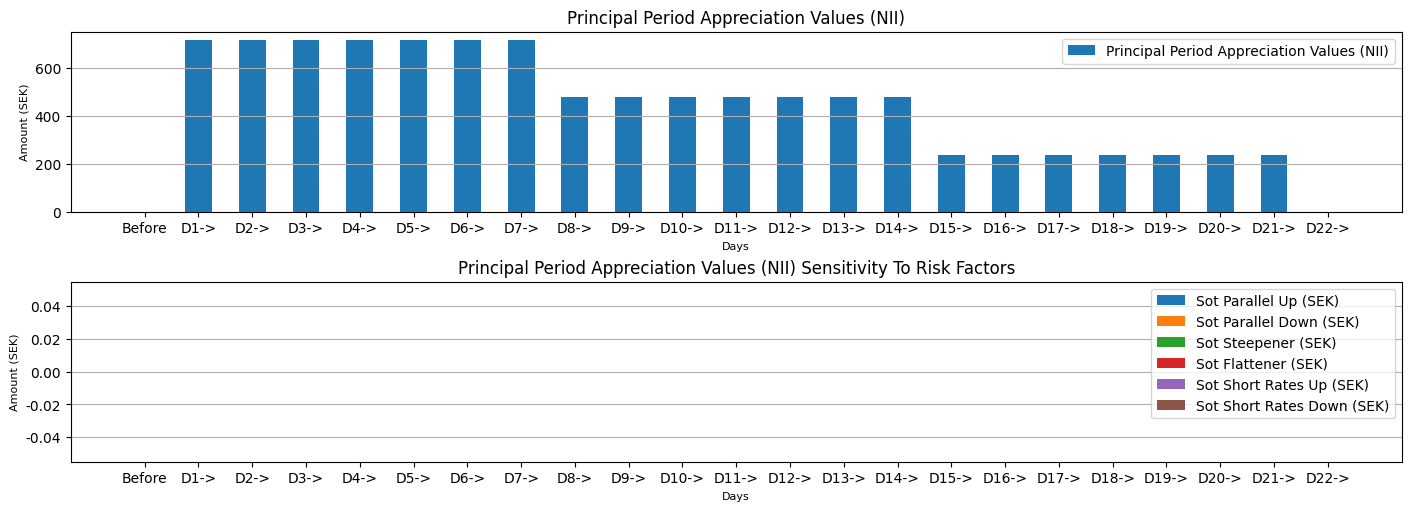

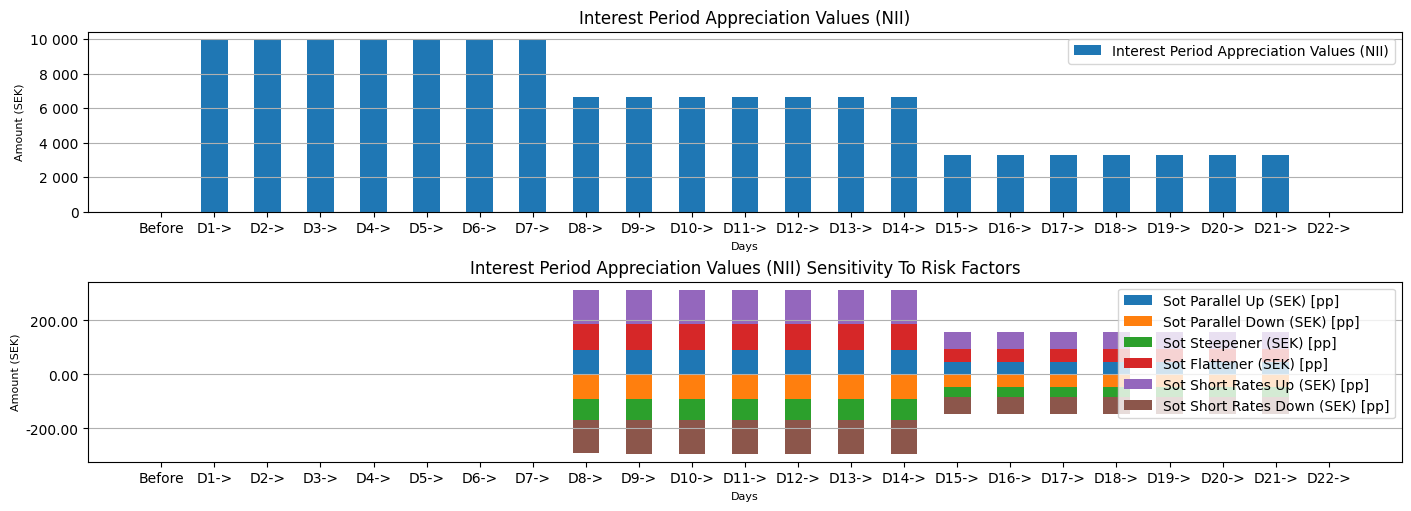

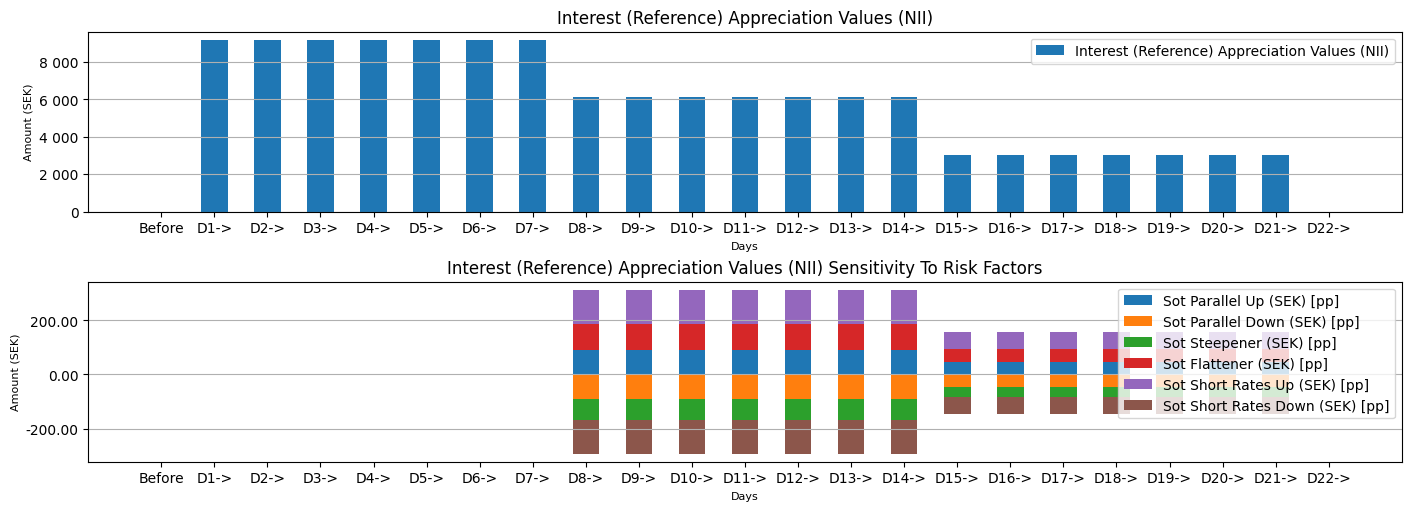

In [37]:
s1 = floatPeriodAppreciationsTableReset.PrincipalPeriodValuesNullable(OuterTape())
s2 = floatPeriodAppreciationsTableReset.InterestPeriodValuesNullable(OuterTape())
s3 = floatPeriodAppreciationsTableReset.InterestPeriodValuesNullable(OuterTape(), floatRateComponents[0])

plt1 = CreatePlot('Principal Period Appreciation Values (NII)',     s1, ['Sot Parallel Up (SEK)', 'Sot Parallel Down (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)', 'Sot Short Rates Up (SEK)', 'Sot Short Rates Down (SEK)'])
plt2 = CreatePlot('Interest Period Appreciation Values (NII)',      s2, ['Sot Parallel Up (SEK)', 'Sot Parallel Down (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)', 'Sot Short Rates Up (SEK)', 'Sot Short Rates Down (SEK)'])
plt3 = CreatePlot('Interest (Reference) Appreciation Values (NII)', s3, ['Sot Parallel Up (SEK)', 'Sot Parallel Down (SEK)', 'Sot Steepener (SEK)', 'Sot Flattener (SEK)', 'Sot Short Rates Up (SEK)', 'Sot Short Rates Down (SEK)'])

plt1.show()
plt2.show()
plt3.show()

---

#### Realized NII
By looking back at the end of the periods we can tabulate the **realized NII** for each time period and compare to the **expected NII** from above, fully in line with how these numbers hit the balance sheet according to IFRS 9.

In [38]:
marketDataMapMap20220726 = JsonSerializer.LoadObjectFromFile[IMarketDataMapMap](os.path.join(pathMarketData, f'MarketDataMapMap 2022-07-26.json'), OuterTape(), '2022-07-26/', loadMap)
marketDataMapMap20220802 = JsonSerializer.LoadObjectFromFile[IMarketDataMapMap](os.path.join(pathMarketData, f'MarketDataMapMap 2022-08-02.json'), OuterTape(), '2022-08-02/', loadMap)

calculatorMapSot20220726 = CalculatorMap(marketDataMapMap20220726.GetMarketDataMap('Sot'))
calculatorMapSot20220802 = CalculatorMap(marketDataMapMap20220802.GetMarketDataMap('Sot'))

floatCalculatorMapsLookback = SimpleList[ICalculatorMap](calculatorMapSot20220726, calculatorMapSot20220802)

floatResetAmortisedSequenceLookback = ResetAmortisedSequence(OuterTape(), floatLoan, currency, floatRateComponents, floatLiquidityCollection, OuterReverse(floatPrincipalEir), SimpleList[OuterReverse](OuterReverse(floatReferenceEir), OuterReverse(floatMarketEir), OuterReverse(floatCreditEir), OuterReverse(floatMarginEir)), floatResets, floatCalculatorMapsLookback, 1.0e-7)

In [39]:
floatPeriodAppreciationsLookback = floatResetAmortisedSequenceLookback.PeriodAppreciations(OuterTape(), date, currency, periodStartDates, -1, False, List[List[OuterReverse]](), None)

floatInterestPeriodAppreciationsLookback = Dictionary[RateComponent, List[OuterReverse]]();

for i in range(len(floatRateComponents)):
    floatInterestPeriodAppreciationsLookback.Add(floatRateComponents[i], floatPeriodAppreciationsLookback[1][i]);
                 
floatPeriodAppreciationsTableLookback = LiquidityCashFlowPeriodsTable(periodStartDates, -1, floatPeriodAppreciationsLookback[0], floatInterestPeriodAppreciationsLookback, False)

CreateDataFrameFloat([[None, floatPeriodAppreciationsTableLookback]], floatRateComponents, False)

,Value,Principal,Interest,Reference,Market,Credit,Margin
Period Start,,,,,,,
Before,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK,0.00 SEK
2022-07-19,10 644.92 SEK,714.27 SEK,9 930.64 SEK,9 158.59 SEK,-4 345.19 SEK,1 645.81 SEK,3 471.43 SEK
2022-07-20,10 645.37 SEK,714.28 SEK,9 931.09 SEK,9 158.98 SEK,-4 345.46 SEK,1 645.89 SEK,3 471.68 SEK
2022-07-21,10 645.82 SEK,714.28 SEK,9 931.54 SEK,9 159.37 SEK,-4 345.73 SEK,1 645.97 SEK,3 471.93 SEK
2022-07-22,10 646.28 SEK,714.28 SEK,9 932.00 SEK,9 159.76 SEK,-4 345.99 SEK,1 646.06 SEK,3 472.18 SEK
2022-07-23,10 646.73 SEK,714.28 SEK,9 932.45 SEK,9 160.14 SEK,-4 346.26 SEK,1 646.14 SEK,3 472.42 SEK
2022-07-24,10 647.18 SEK,714.29 SEK,9 932.90 SEK,9 160.53 SEK,-4 346.53 SEK,1 646.22 SEK,3 472.67 SEK
2022-07-25,10 647.64 SEK,714.29 SEK,9 933.35 SEK,9 160.92 SEK,-4 346.80 SEK,1 646.31 SEK,3 472.92 SEK
2022-07-26,7 084.11 SEK,476.19 SEK,6 607.92 SEK,6 093.21 SEK,-2 896.86 SEK,1 097.23 SEK,2 314.34 SEK
